In [1]:
import os
import sys
import pdb
import copy
import json
import pickle
import numpy as np
import pandas as pd
import soundfile as sf
import soxr
import scipy.fft

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model

sys.path.append('/om2/user/msaddler/spatial_audio_pipeline/spatial_audio_util')
import util_audio

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


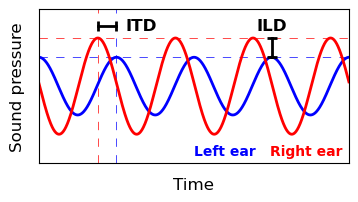

In [2]:
sr = 1e3
dur = 1.0
f = 4
itd = 0.06
ild = 0.6
t = np.arange(0, dur, 1/sr)
yl = np.cos(2 * np.pi * f * t) * ild
yr = np.cos(2 * np.pi * f * (t + itd))
y = np.stack([yl, yr], axis=1)

n_periods = 1
tl = n_periods * (1 / f)
tr = n_periods * (1 / f) - itd
al = ild
ar = 1

fig, ax = plt.subplots(figsize=(4, 2))
kwargs_plot = {
    'lw': 2
}
kwargs_axline = {
    'lw': 0.5,
    'ls': '--',
    'dashes': (12, 12),
}

ax.axvline(tl, color='b', **kwargs_axline)
ax.axvline(tr, color='r', **kwargs_axline)
ax.axhline(al, color='b', **kwargs_axline)
ax.axhline(ar, color='r', **kwargs_axline)
ax.plot(t, y[:, 0], color='b', **kwargs_plot)
ax.plot(t, y[:, 1], color='r', **kwargs_plot)

yt = 1.25
ax.plot([tr, tl], [yt, yt], lw=2, color='k', marker='|', mew=2, ms=7.5)
kwargs_text = {
    'fontsize': 12,
    'fontweight': 'bold'
}
ax.text(
    tl + 0.03,
    yt,
    'ITD',
    horizontalalignment='left',
    verticalalignment='center',
    **kwargs_text)

x = 0.75
ax.plot([x, x], [al, ar], lw=2, color='k', marker='_', mew=2, ms=7.5)
kwargs_text = {
    'fontsize': 12,
    'fontweight': 'bold'
}
ax.text(
    x,
    ar + 0.1,
    'ILD',
    horizontalalignment='center',
    verticalalignment='bottom',
    **kwargs_text)
yt = 1.25
ax.text(
    0.5,
    -yt-0.1,
    'Left ear',
    color='b',
    fontsize=10,
    fontweight='bold',
    horizontalalignment='left',
    verticalalignment='center')
ax.text(
    0.98,
    -yt-0.1,
    'Right ear',
    color='r',
    fontsize=10,
    fontweight='bold',
    horizontalalignment='right',
    verticalalignment='center')

ax = util_figures.format_axes(
    ax,
    xlimits=[t[0], t[-1]],
    ylimits=[y.min()*1.6, y.max()*1.6],
    yticks=[],
    xticks=[],
    str_xlabel='Time',
    str_ylabel='Sound pressure',
#     spines_to_hide=['left', 'right', 'top', 'bottom'],
)
plt.show()

fn_fig = 'figures_src/schematic_localization_cue_interaural.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)


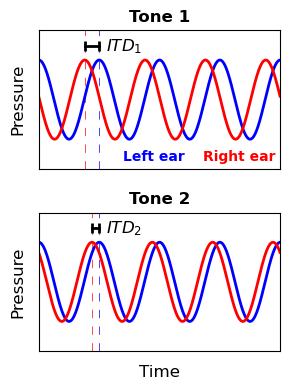

In [2]:
sr = 1e3
dur = 1.0
f = 4

list_itd = [0.06, 0.03]
fig, ax_arr = plt.subplots(figsize=(3, 4), nrows=2, ncols=1, sharex=True)
for itr_ax, itd in enumerate(list_itd):
    ax = ax_arr[itr_ax]
    t = np.arange(0, dur, 1/sr)
    yl = np.cos(2 * np.pi * f * t)
    yr = np.cos(2 * np.pi * f * (t + itd))
    y = np.stack([yl, yr], axis=1)
    n_periods = 1
    tl = n_periods * (1 / f)
    tr = n_periods * (1 / f) - itd
    kwargs_plot = {
        'lw': 2
    }
    kwargs_axline = {
        'lw': 0.5,
        'ls': '--',
        'dashes': (12, 12),
    }
    ax.axvline(tl, color='b', **kwargs_axline)
    ax.axvline(tr, color='r', **kwargs_axline)
    ax.plot(t, y[:, 0], color='b', **kwargs_plot)
    ax.plot(t, y[:, 1], color='r', **kwargs_plot)
    yt = 1.35
    ax.plot([tr, tl], [yt, yt], lw=2, color='k', marker='|', mew=2, ms=7.5)
    kwargs_text = {
        'fontsize': 12,
        'fontweight': 'bold'
    }
    ax.text(
        tl + 0.03,
        yt,
        r'$ITD_{}$'.format(itr_ax + 1),
        horizontalalignment='left',
        verticalalignment='center',
        **kwargs_text)
    if itr_ax == 0:
        ax.text(
            0.35,
            -yt-0.1,
            'Left ear',
            color='b',
            fontsize=10,
            fontweight='bold',
            horizontalalignment='left',
            verticalalignment='center')
        ax.text(
            0.98,
            -yt-0.1,
            'Right ear',
            color='r',
            fontsize=10,
            fontweight='bold',
            horizontalalignment='right',
            verticalalignment='center')
    ax = util_figures.format_axes(
        ax,
        xlimits=[t[0], t[-1]],
        ylimits=[y.min()*1.75, y.max()*1.75],
        yticks=[],
        xticks=[],
        str_title='Tone {}'.format(itr_ax + 1),
        fontweight_title='bold',
        str_xlabel='Time' if itr_ax == 1 else None,
        str_ylabel='Pressure'
    )
    ax.set_facecolor('w')
fig.patch.set_color('none')
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/schematic_localization_itd_discrimination.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)


In [4]:
df_brir = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_brir.pdpkl')
df_brir = df_brir[np.logical_and.reduce([
    df_brir.index_room == 0,
    df_brir.src_dist == 1.4,
    df_brir.src_elev.isin([-30, 0, 30]),
    df_brir.src_azim.isin([0]),
])]
df_brir = df_brir.sort_values(by='src_elev', ascending=False)
brir, sr_brir = util_audio.load_brir(
    index_room=0,
    index_brir=list(df_brir.index.values),
    fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/room{:04.0f}.hdf5',
    return_metadata=False,
    verbose=False)
list_elev = df_brir.src_elev.values


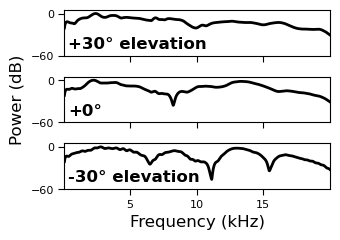

In [5]:
fig, ax_arr = plt.subplots(nrows=len(list_elev), ncols=1, figsize=(3.5, 2.5), sharex=True)
for itr in range(len(list_elev)):
    ax = ax_arr[itr]
    elev = list_elev[itr]
    x = brir[itr, :, 0]
    
    fxx, pxx = util_stimuli.power_spectrum(x, sr_brir[0])
    fxx = fxx / 1e3
    pxx = pxx - pxx.max()
    
    ax.plot(fxx, pxx, lw=2, color='k')
    label = '{:+.0f}° elevation'.format(elev)
    if elev == 0:
        label = label.replace(' elevation', '')
    ax.text(
        0.4,
        -50,
        label,
        fontweight='bold',
        fontsize=12)
    ax = util_figures.format_axes(
        ax,
        xscale='linear',
        xlimits=[0.1, 20],
        ylimits=[-60, 5],
        yticks=np.arange(-60, 1, 60),
        xticks=np.arange(5, 20, 5),
        fontsize_ticks=8,
        str_ylabel='Power (dB)' if itr == 1 else None,
        str_xlabel='Frequency (kHz)' if itr == 2 else None,
    )
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/schematic_localization_cue_elevation.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)


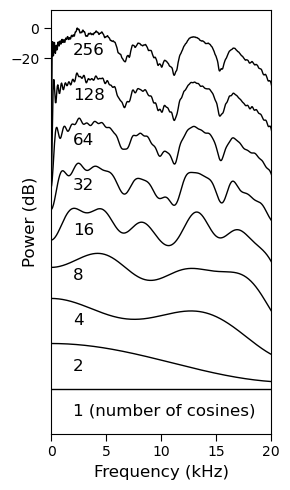

figures_src/schematic_localization_spectral_smoothing.pdf


In [47]:
df_brir = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_brir.pdpkl')
df_brir = df_brir[np.logical_and.reduce([
    df_brir.index_room == 0,
    df_brir.src_dist == 1.4,
    df_brir.src_elev.isin([-30]),
    df_brir.src_azim.isin([350]),
])]
df_brir = df_brir.sort_values(by='src_elev', ascending=False)
brir, sr_brir = util_audio.load_brir(
    index_room=0,
    index_brir=list(df_brir.index.values),
    fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/room{:04.0f}.hdf5',
    return_metadata=False,
    verbose=False)
list_elev = df_brir.src_elev.values
brir_src = brir[0, :, 0]

fig, ax = plt.subplots(figsize=(3, 5))
for itr, n in enumerate([256, 128, 64, 32, 16, 8, 4, 2, 1]):    
    x_rfft = scipy.fft.rfft(brir_src[:1024]) # Kulkarni & Colburn used 1024-tap HRIRs
    x_rfft_log_mag = np.log(np.abs(x_rfft)) # Approximate log-magnitude spectrum with DCT
    dct_x_rfft_log_mag = scipy.fft.dct(x_rfft_log_mag, norm='ortho')
    dct_x_rfft_log_mag[n:] = 0 # DCT coefficients after the nth are set to 0
    x_rfft_log_mag = scipy.fft.idct(dct_x_rfft_log_mag, norm='ortho')
    x_rfft = np.exp(x_rfft_log_mag)
    x = scipy.fft.irfft(x_rfft)
    fxx, pxx = util_stimuli.power_spectrum(x, sr_brir[0])
    fxx = fxx / 1e3
    pxx = pxx - pxx.max()
    kwargs_plot = {
        'color': 'k',
        'lw': 1,
    }
    ax.plot(fxx, pxx - itr * 30, label=n, **kwargs_plot)
    ax.text(
        2,
        -itr * 30 - 10,
        n if n > 1 else f'{n} (number of cosines)',
        va='top',
        ha='left',
        fontsize=12)
ax = util_figures.format_axes(
    ax,
    xscale='linear',
    xlimits=[0, 20],
    ylimits=[-itr * 30 - 30, None],
    yticks=[0, -20],
    xticks=np.arange(0, 21, 5),
    fontsize_ticks=10,
    str_ylabel='Power (dB)',
    str_xlabel='Frequency (kHz)',
)
ax.set_ylabel('Power (dB)', labelpad=-20)
plt.tight_layout()
plt.show()

# fn_fig = 'figures_src/schematic_localization_spectral_smoothing.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
# print(fn_fig)


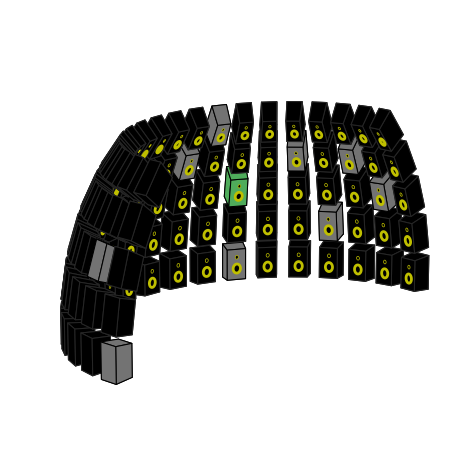

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np


def make_speaker(
        ax,
        azim,
        elev,
        r=2,
        da=3,
        de=4,
        dr=0.1,
        first_box=True,
        kwargs_box_update={},
        kwargs_circ0_update={},
        kwargs_circ1_update={}):
    """
    """
    verts_box = []
    for sa in [-1, 1]:
        vert = []
        for (sr, se) in [(-1, 1), (-1, -1), (1, -1), (1, 1)]:
            alpha = azim + sa * da
            polar = 90 - (elev + se * de)
            x = (r + dr * sr) * np.sin(np.deg2rad(polar)) * np.cos(np.deg2rad(alpha))
            y = (r + dr * sr) * np.sin(np.deg2rad(polar)) * np.sin(np.deg2rad(alpha))
            z = (r + dr * sr) * np.cos(np.deg2rad(polar))
            vert.append([x, y, z])
        verts_box.append(vert)
    for se in [-1, 1]:
        vert = []
        for (sr, sa) in [(-1, 1), (-1, -1), (1, -1), (1, 1)]:
            alpha = azim + sa * da
            polar = 90 - (elev + se * de)
            x = (r + dr * sr) * np.sin(np.deg2rad(polar)) * np.cos(np.deg2rad(alpha))
            y = (r + dr * sr) * np.sin(np.deg2rad(polar)) * np.sin(np.deg2rad(alpha))
            z = (r + dr * sr) * np.cos(np.deg2rad(polar))
            vert.append([x, y, z])
        verts_box.append(vert)
    for sr in [1, -1]:
        vert = []
        for (sa, se) in [(-1, 1), (-1, -1), (1, -1), (1, 1)]:
            alpha = azim + sa * da
            polar = 90 - (elev + se * de)
            x = (r + dr * sr) * np.sin(np.deg2rad(polar)) * np.cos(np.deg2rad(alpha))
            y = (r + dr * sr) * np.sin(np.deg2rad(polar)) * np.sin(np.deg2rad(alpha))
            z = (r + dr * sr) * np.cos(np.deg2rad(polar))
            vert.append([x, y, z])
        verts_box.append(vert)
    
    verts_circ0 = []
    vert = []
    for _ in range(0, 360, 15):
        r_circ0 = 1.2
        alpha = azim + sa * (np.sin(np.deg2rad(_)) * r_circ0)
        polar = 90 - (elev - de/4 + se * (np.cos(np.deg2rad(_)) * r_circ0))
        x = (r - dr) * np.sin(np.deg2rad(polar)) * np.cos(np.deg2rad(alpha))
        y = (r - dr) * np.sin(np.deg2rad(polar)) * np.sin(np.deg2rad(alpha))
        z = (r - dr) * np.cos(np.deg2rad(polar))
        vert.append([x, y, z])
    verts_circ0.append(vert)
    verts_circ1 = []
    vert = []
    for _ in range(0, 360, 15):
        r_circ0 = 0.5
        alpha = azim + sa * (np.sin(np.deg2rad(_)) * r_circ0)
        polar = 90 - (elev + de/2 + se * (np.cos(np.deg2rad(_)) * r_circ0))
        x = (r - dr) * np.sin(np.deg2rad(polar)) * np.cos(np.deg2rad(alpha))
        y = (r - dr) * np.sin(np.deg2rad(polar)) * np.sin(np.deg2rad(alpha))
        z = (r - dr) * np.cos(np.deg2rad(polar))
        vert.append([x, y, z])
    verts_circ1.append(vert)
    
    kwargs_box = {
        'fc': 'k',
        'ec': [0.15] * 3,
        'lw': 0.75,
    }
    kwargs_box.update(kwargs_box_update)
    kwargs_circ0 = {
        'fc': 'k',
        'ec': 'y',
        'lw': 2.,
    }
    kwargs_circ0.update(kwargs_circ0_update)
    kwargs_circ1 = {
        'fc': 'k',
        'ec': 'y',
        'lw': 0.5,
    }
    kwargs_circ1.update(kwargs_circ1_update)
    if first_box:
        ax.add_collection3d(Poly3DCollection(verts_box, **kwargs_box))
        ax.add_collection3d(Poly3DCollection(verts_circ0, **kwargs_circ0))
        ax.add_collection3d(Poly3DCollection(verts_circ1, **kwargs_circ1))
    else:
        ax.add_collection3d(Poly3DCollection(verts_circ0, **kwargs_circ0))
        ax.add_collection3d(Poly3DCollection(verts_circ1, **kwargs_circ1))
        ax.add_collection3d(Poly3DCollection(verts_box, **kwargs_box))
    return ax


list_azim_elev_target = [(30, 20)]
list_azim_elev_noise = [
    (50, 30),
    (-90, 0),
    (80, 20),
    (30, 0),
    (70, 30),
    (20, 40),
    (60, 10),
    (10, 30),
    (-80, 20),
]
list_azim_elev_target = [(-azim, elev) for (azim, elev) in list_azim_elev_target]
list_azim_elev_noise = [(-azim, elev) for (azim, elev) in list_azim_elev_noise]

subplot_kw={
    'projection':'3d',
    'computed_zorder': False,
}
fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize=plt.figaspect(1.0))
itr = 0
list_azim = [-60, -70, -80, -90] + np.arange(-50, 91, 10).tolist()
list_elev = np.arange(0, 41, 10)
for azim in list_azim:
    for elev in list_elev:
        kwargs_box_update = {}
        if (azim, elev) in list_azim_elev_target:
            kwargs_box_update = {
                'fc': np.array([79, 173, 91]) / 256,
                'ec': 'k',
            }
        elif (azim, elev) in list_azim_elev_noise:
            kwargs_box_update = {
                'fc': [0.45] * 3,
                'ec': 'k',
            }
        ax = make_speaker(
            ax,
            azim,
            elev,
            first_box = azim < 60,
            kwargs_box_update=kwargs_box_update)

ax.view_init(15, 135)
ax.set_xlim([0, 1])
ax.set_ylim([-2, 2])
ax.set_zlim([0.25, 1])
ax.set_box_aspect(aspect=(1, 4.5, 1))
ax.set_axis_off()
plt.tight_layout()
plt.show()

# fn_fig = 'figures_src/schematic_localization_speaker_array.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=-0.25, transparent=True)
# print(fn_fig)


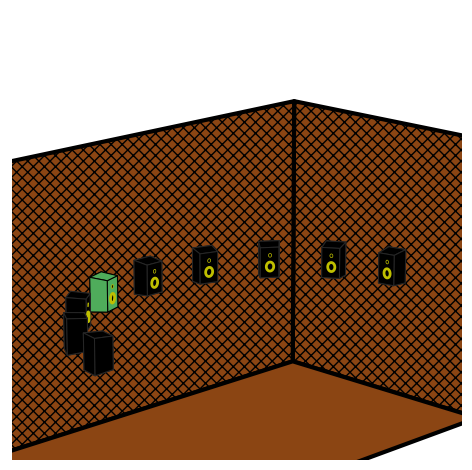

figures_src/schematic_localization_speaker_array_9AFC_saddlebrown.pdf


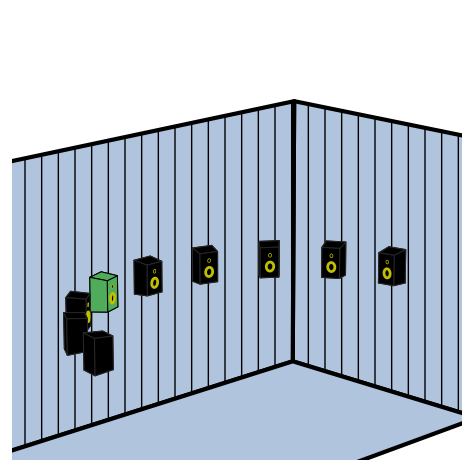

figures_src/schematic_localization_speaker_array_9AFC_lightsteelblue.pdf


In [91]:
for fc, hatch_wall, hatch_floor in [('saddlebrown', '///\\\\\\', ''), ('lightsteelblue', '|', '')]:
    subplot_kw={
        'projection':'3d',
        'computed_zorder': False,
    }
    fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize=plt.figaspect(1.0))
    verts_wall0 = [
        [3, -3, -1.5],
        [3, -3, 1],
        [0, -3, 1],
        [0, -3, -1.5],
    ]
    verts_wall1 = [
        [3, 3, -1.5],
        [3, 3, 1],
        [3, -3, 1],
        [3, -3, -1.5],
    ]
    verts_floor = [
        [3, 3, -1.5],
        [3, -3, -1.5],
        [0, -3, -1.5],
        [0, 3, -1.5],
    ]
    kwargs_box = {
        'lw': 3,
        'ec': 'k',
    }
    ax.add_collection3d(Poly3DCollection([verts_wall0, verts_wall1], **kwargs_box, fc=fc, hatch=hatch_wall))
    ax.add_collection3d(Poly3DCollection([verts_floor], **kwargs_box, fc=fc, hatch=hatch_floor))
    itr = 0
    list_azim = [-60, -80] + np.arange(-40, 81, 20).tolist()
    # list_azim = [-60, -70, -80, -90] + np.arange(-50, 91, 10).tolist()
    list_elev = [0]
    for azim in list_azim:
        for elev in list_elev:
            kwargs_box_update = {}
            if azim == 20:
                kwargs_box_update = {
                    'fc': np.array([79, 173, 91]) / 256,
                    'ec': 'k',
                }
            # elif azim % 20 == 0:
            #     kwargs_box_update = {
            #         'fc': [0.45] * 3,
            #         'ec': 'k',
            #     }
            ax = make_speaker(
                ax,
                azim,
                elev,
                first_box = azim < 60,
                kwargs_box_update=kwargs_box_update)
    
    ax.view_init(15, 135)
    ax.set_xlim([0, 1])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0.25, 1])
    ax.set_box_aspect(aspect=(1, 4.5, 1))
    # ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    
    fn_fig = f'figures_src/schematic_localization_speaker_array_9AFC_{fc}.pdf'
    fig.savefig(fn_fig, bbox_inches='tight', pad_inches=-0.25, transparent=True)
    print(fn_fig)
